In [1]:
import sys
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/wilson/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
from llc import *
import gc
from collections import defaultdict

%load_ext autoreload
%autoreload 2

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [39]:
# path = '/workspace/models/2024_08_05_18_31_53_S_5__times_A_5__Z_2__'
#path = '/workspace/models/2024_08_09_02_36_30_S5_MLP3_corrected_inits'
# path = '/workspace/wilson/Finite-groups/models/2024-08-09_17-22-34_B_5_'
path = '/workspace/wilson/Finite-groups/models/2024-08-09_18-01-35_B5_long'

models, params = load_models(path, sel='final')

100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


In [40]:
data = GroupData(params)

Intersection size: 1024/1024 (1.00)
Added 1024 elements from intersection
Added 0 elements from group 0: B(5)
Taking random subset: 409/1024 (0.40)
Train set size: 409/1024 (0.40)


In [41]:
def part_var(x, part, dim):
    '''
    Computes E[var(x | part)] / var(x), where part is a partition of x along dim.
    By the law of total variance, this quantity is in [0, 1].
    Stander et al instead compute (\sum_part var(x | part)) / var(x), which is less principled.
    '''
    part = list(map(list, part))
    assert sorted(sum(part, [])) == list(range(x.shape[dim])), "part must be a partition of x along dim"
    denom = x.var(dim=dim, correction=0)
    num = sum(
        x.index_select(dim, t.Tensor(p).int().to(x.device)).var(dim=dim, correction=0) * (len(p) / x.shape[dim])
        for p in part
    )
    return (num / denom).nan_to_num(nan=0.)

In [42]:
subgroups = {
    i: {sg for sg in data.groups[i].get_subgroups_idx()}
    for i in range(len(data.groups))
}

In [43]:
left_cosets = {
    i: {
        subgroup: data.groups[i].get_cosets_idx(subgroup, left=True)
        for subgroup in subgroups[i]
    }
    for i in range(len(data.groups))
}
right_cosets = {
    i: {
        subgroup: data.groups[i].get_cosets_idx(subgroup, left=False)
        for subgroup in subgroups[i]
    }
    for i in range(len(data.groups))
}

In [46]:
instance = 70
model = models[0][instance]

In [56]:
left_neurons, right_neurons = model.get_neurons()
left_neurons = left_neurons.squeeze(0)
right_neurons = right_neurons.squeeze(0)
unembed = model.unembedding.data.squeeze(0)

In [11]:
# hypothesis is that left neurons are constant on *right* cosets
left_coset_vars = {
    i: {
        subgroup: part_var(left_neurons, right_cosets[i][subgroup], dim=0)
        for subgroup in right_cosets[i].keys()
    }
    for i in range(len(data.groups))
}

In [25]:
left_neuron_cosets = dict()
group = 0
for neuron in range(left_neurons.shape[1]):
    left_neuron_cosets[neuron] = None
    for subgroup in subgroups[group]:
        if left_coset_vars[group][subgroup][neuron] < 1e-1:
            if left_neuron_cosets[neuron] is None or len(left_neuron_cosets[neuron]) < len(subgroup):
                left_neuron_cosets[neuron] = subgroup

In [26]:
named_subgroups = {
    # [s for s in subgroups[0] if len(s) == 1][0]: 'e',
    # [s for s in subgroups[0] if len(s) == 60][0]: 'A5',
    # [s for s in subgroups[0] if len(s) == 120][0]: 'S5',
}
A4_count = 0
S4_count = 0
order_counts = defaultdict(lambda: 0)
for s in subgroups[0]:
    # if len(s) == 24:
    #     named_subgroups[s] = f'S_4^{S4_count}'  # not the correct index but whatever
    #     S4_count += 1
    # elif len(s) == 12:
    #     named_subgroups[s] = f'A_4^{A4_count}'  # not the correct index but whatever
    #     A4_count += 1
    # elif len(s) not in [1, 60, 120]:
    named_subgroups[s] = f'{len(s)}^{order_counts[len(s)]}'
    order_counts[len(s)] += 1
        

In [27]:
named_subgroups.values()

dict_values(['4^0', '4^1', '4^2', '4^3', '4^4', '8^0', '4^5', '2^0', '2^1', '8^1', '8^2', '8^3', '4^6', '16^0', '2^2', '8^4', '8^5', '8^6', '4^7', '8^7', '8^8', '4^8', '4^9', '16^1', '4^10', '4^11', '4^12', '16^2', '8^9', '4^13', '4^14', '8^10', '4^15', '8^11', '16^3', '4^16', '4^17', '4^18', '4^19', '8^12', '8^13', '8^14', '8^15', '8^16', '8^17', '16^4', '4^20', '4^21', '8^18', '4^22', '8^19', '4^23', '8^20', '8^21', '8^22', '16^5', '8^23', '8^24', '4^24', '4^25', '4^26', '8^25', '4^27', '4^28', '4^29', '16^6', '2^3', '2^4', '16^7', '4^30', '4^31', '4^32', '4^33', '4^34', '8^26', '4^35', '2^5', '8^27', '8^28', '8^29', '8^30', '8^31', '4^36', '4^37', '4^38', '4^39', '4^40', '2^6', '8^32', '8^33', '8^34', '8^35', '8^36', '4^41', '8^37', '8^38', '4^42', '4^43', '4^44', '4^45', '8^39', '4^46', '16^8', '8^40', '8^41', '8^42', '8^43', '4^47', '4^48', '2^7', '8^44', '4^49', '8^45', '8^46', '4^50', '16^9', '16^10', '1^0', '4^51', '8^47', '8^48', '2^8', '8^49', '4^52', '4^53', '4^54', '8^50', 

In [28]:
subgroup_counts = defaultdict(lambda: 0)
for subgroup in left_neuron_cosets.values():
    subgroup_counts[named_subgroups[subgroup]] += 1    
subgroup_counts

defaultdict(<function __main__.<lambda>()>,
            {'16^25': 4,
             '16^11': 6,
             '2^6': 1,
             '1^0': 22,
             '16^5': 3,
             '2^7': 2,
             '16^30': 2,
             '16^24': 2,
             '4^46': 1,
             '8^108': 1,
             '8^50': 1,
             '8^118': 1,
             '2^4': 1,
             '4^40': 1,
             '16^3': 3,
             '16^8': 3,
             '16^29': 3,
             '16^23': 3,
             '8^89': 1,
             '4^33': 1,
             '8^23': 1,
             '8^70': 1})

In [38]:
left_neurons[:,5]

tensor([0.1821, 0.1497, 0.1556, 0.2028, 0.1807, 0.1509, 0.1881, 0.1328, 0.1375,
        0.2120, 0.2166, 0.1889, 0.1325, 0.2089, 0.2264, 0.1576, 0.1482, 0.1087,
        0.1322, 0.0988, 0.0862, 0.1892, 0.0561, 0.1250, 0.1220, 0.1690, 0.1899,
        0.2104, 0.2252, 0.0892, 0.2040, 0.1021])

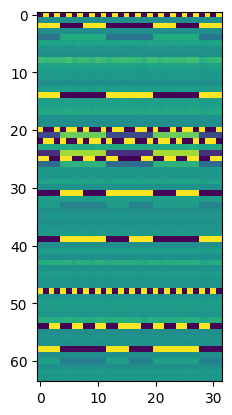

In [51]:
plt.imshow(left_neurons.numpy().T)

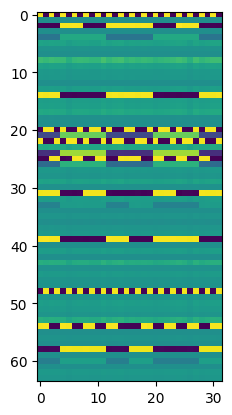

In [53]:
plt.imshow(right_neurons.numpy().T)

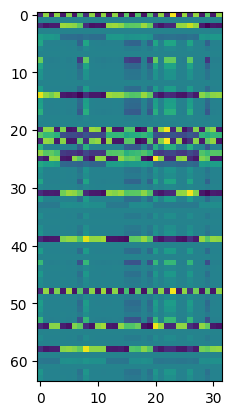

In [57]:
plt.imshow(unembed.numpy())